In [1]:
import pandas as pd
from pandas.api.types import is_string_dtype,is_numeric_dtype
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt

# To use the experimental IterativeImputer, we need to explicitly ask for it:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer, MissingIndicator
from fancyimpute import BiScaler, KNN, NuclearNormMinimization, SoftImpute ,SimpleFill
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from matplotlib import pyplot as plt
import seaborn as sns
import joblib

%matplotlib inline



Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Check the path to the directory where you are currently in
%pwd
mypath = %pwd

In [3]:
my_df = pd.read_csv(f'{mypath}/Titanic_full.csv')
print(my_df.shape)
my_df.head(3)

(1309, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [4]:
'''As we have seen, it's important to avoid the Texas sharp shooter logical
fallacy. So, we plit the data into three sets in a 70-15-15 manner. 
This means 70% of the data rows go into building or training the model. 
This 70% is often called a training set. 15% of the data goes into 
evaluating model performance as you manually change or set the model 
hyperparameters (e.g. Value of K is a hyperparameter,in K-NN algorithm). 
This dataset is sometimes called a holdout set or the validation set. 
Finally, the last 15% of the data is the test set.  This dataset is 
never "seen" by the model for model building or hyperparamter tuning. After
hyperparameter tuning and model selection, which we will discuss later,
the model's final performance before sneidng it to production, will be
evalauted on this test data set.
The way the datarows are distributed will depend on the type of problem. 
Here, assuming the datarows of my_df are randomly arranged, and there's
no time component, we will simply simply do the split, using a split 
function that we define. Also, this 15% split 
for the test set may change, if the actual test set size is predefined. 
In any case we will make sure the test set we choose from our dataset 
is as similar as it can get to the actual data that it will see in 
production'''

#Calculate 15% of 1309. This is about 209 rows of data. 
#So, 1309 - 209 = 1100 rows of data will remain for the
#train and valid sets which we will separate later. 200 rows of data will
#go as test set data

def mydf_splitter(my_df,num_rows):
    return my_df[:num_rows].copy(),my_df[num_rows:]


mydf_train_valid,mydf_test = mydf_splitter(my_df,1150)

print(mydf_train_valid.shape,mydf_test.shape)

#We are going to put away the mydf_test for now. 
#We will return to it later.

(1150, 12) (159, 12)


In [5]:
import pandas_profiling
pandas_profiling.ProfileReport(mydf_train_valid)

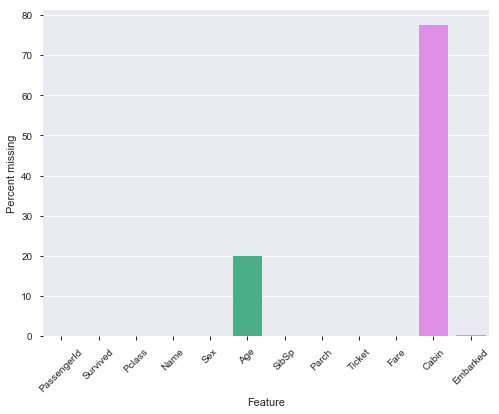

In [6]:
''' Deal with missing values. First, calculate the percentage of
missing values for every column, and plot them as a bar chart'''

null_vals = mydf_train_valid.isnull().sum()/len(mydf_train_valid)*100
null_vals = pd.DataFrame(null_vals)
null_vals.reset_index(inplace = True)
null_vals.columns = ["Feature","Percent missing"]
plt.figure(figsize = (8,6))
plt.xticks(rotation=45)
sns.barplot(x = "Feature",y ="Percent missing",data = null_vals)

In [7]:
mydf_train_valid.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            230
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          890
Embarked         2
dtype: int64

In [8]:
mydf_train_valid.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C


mydf_train_valid_1 = mydf_train_valid.drop("Cabin",axis = 1)
print(mydf_train_valid_1.shape)
mydf_train_valid_1.head(2)



In [9]:
mydf_train_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null object
Sex            1150 non-null object
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null object
Fare           1149 non-null float64
Cabin          260 non-null object
Embarked       1148 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 107.9+ KB


In [10]:
'''You can see that several of the columns or features are "object" type
These need to be changed to category before we can convert those to 
mappings and numbers'''
#1 (a) Define a function to convert object types and string types to category type

def str_to_cat(my_df):
    for p,q in my_df.items(): #my_df.items() is a generator in Python
        if is_string_dtype(q): 
            my_df[p] = q.astype('category').cat.as_ordered()
    return my_df

In [11]:
mydf_train_valid_2 = str_to_cat(mydf_train_valid)

In [12]:
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null category
Sex            1150 non-null category
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null category
Fare           1149 non-null float64
Cabin          260 non-null category
Embarked       1148 non-null category
dtypes: category(5), float64(2), int64(5)
memory usage: 174.0 KB


In [13]:
print(mydf_train_valid_2.Embarked.cat.categories)
print(mydf_train_valid_2.Sex.cat.categories)

Index(['C', 'Q', 'S'], dtype='object')
Index(['female', 'male'], dtype='object')


In [14]:
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null category
Sex            1150 non-null category
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null category
Fare           1149 non-null float64
Cabin          260 non-null category
Embarked       1148 non-null category
dtypes: category(5), float64(2), int64(5)
memory usage: 174.0 KB


In [15]:
'''Define impute functions. Impute categorical NaNs with -1, 
where we add 1 to make it 0. For each 
continuous variables, we impute missing values with median values of that
column, and for every variable
where any rows were imputed, add a separate 'imputed or not' column'''

def mydf_to_nums(my_df, feature, null_status):
    if not is_numeric_dtype(feature):
        my_df[null_status] = feature.cat.codes + 1

def mydf_preprocessor(my_df, null_table):
    '''null_table  = your table or None'''
    
    if null_table is None: 
        null_table = dict()
    for p,q in my_df.items(): 
        mydf_to_nums(my_df, q, p)
    my_df = pd.get_dummies(my_df, dummy_na = True)
    res = [my_df, null_table]
    return res

mydf_train_valid_2,my_table = mydf_preprocessor(mydf_train_valid_1,null_table = None)

my_table

In [16]:
mydf_train_valid_2.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

mydf_train_valid_2['Age'] = mydf_train_valid_2['Age'].fillna(0).astype(np.int64)
mydf_train_valid_2['Fare'] = mydf_train_valid_2['Fare'].fillna(0).astype(np.int64)


In [17]:
print(mydf_train_valid_2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null category
Sex            1150 non-null category
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null category
Fare           1149 non-null float64
Cabin          260 non-null category
Embarked       1148 non-null category
dtypes: category(5), float64(2), int64(5)
memory usage: 174.0 KB
None


In [18]:
mydf_train_valid_3,my_table = mydf_preprocessor(mydf_train_valid_2,null_table = None)

In [19]:
mydf_train_valid_2.shape

(1150, 12)

In [20]:
mydf_train_valid_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150 entries, 0 to 1149
Data columns (total 12 columns):
PassengerId    1150 non-null int64
Survived       1150 non-null int64
Pclass         1150 non-null int64
Name           1150 non-null int16
Sex            1150 non-null int8
Age            920 non-null float64
SibSp          1150 non-null int64
Parch          1150 non-null int64
Ticket         1150 non-null int16
Fare           1149 non-null float64
Cabin          1150 non-null int16
Embarked       1150 non-null int8
dtypes: float64(2), int16(3), int64(5), int8(2)
memory usage: 72.0 KB


In [21]:
my_table

{}

In [22]:
X = mydf_train_valid_2[['PassengerId', 'Pclass', 'Name', 'Sex', 'SibSp', 'Parch',
       'Ticket', 'Embarked']]
Y = mydf_train_valid_2['Survived']
X_incomplete =mydf_train_valid_2[['Age','Cabin']]

# KNN impute with RF and KNN

In [23]:
from sklearn.model_selection import train_test_split, cross_val_score

clf = RandomForestClassifier()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)

X_filled_knn_df = pd.DataFrame({'Age':X_filled_knn[:,0],'Cabin':X_filled_knn[:,1]})

tdf = [X, X_filled_knn_df]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

Imputing row 1/1150 with 0 missing, elapsed time: 0.176
Imputing row 101/1150 with 0 missing, elapsed time: 0.177
Imputing row 201/1150 with 0 missing, elapsed time: 0.178
Imputing row 301/1150 with 1 missing, elapsed time: 0.179
Imputing row 401/1150 with 0 missing, elapsed time: 0.180
Imputing row 501/1150 with 0 missing, elapsed time: 0.181
Imputing row 601/1150 with 0 missing, elapsed time: 0.182
Imputing row 701/1150 with 0 missing, elapsed time: 0.183
Imputing row 801/1150 with 0 missing, elapsed time: 0.184
Imputing row 901/1150 with 0 missing, elapsed time: 0.185
Imputing row 1001/1150 with 0 missing, elapsed time: 0.186
Imputing row 1101/1150 with 0 missing, elapsed time: 0.187


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7648830847734029

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
X_filled_knn = KNN(k=3).fit_transform(X_incomplete)

X_filled_knn_df = pd.DataFrame({'Age':X_filled_knn[:,0],'Cabin':X_filled_knn[:,1]})

tdf = [X, X_filled_knn_df]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

Imputing row 1/1150 with 0 missing, elapsed time: 0.180
Imputing row 101/1150 with 0 missing, elapsed time: 0.181
Imputing row 201/1150 with 0 missing, elapsed time: 0.182
Imputing row 301/1150 with 1 missing, elapsed time: 0.183
Imputing row 401/1150 with 0 missing, elapsed time: 0.184
Imputing row 501/1150 with 0 missing, elapsed time: 0.185
Imputing row 601/1150 with 0 missing, elapsed time: 0.186
Imputing row 701/1150 with 0 missing, elapsed time: 0.187
Imputing row 801/1150 with 0 missing, elapsed time: 0.188
Imputing row 901/1150 with 0 missing, elapsed time: 0.189
Imputing row 1001/1150 with 0 missing, elapsed time: 0.190
Imputing row 1101/1150 with 0 missing, elapsed time: 0.191


0.5999355585365213

# SoftImpute with RF and KNN

In [25]:
from sklearn.model_selection import train_test_split, cross_val_score

clf = RandomForestClassifier()
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete)

X_filled_softimpute = pd.DataFrame({'Age':X_filled_softimpute[:,0],'Cabin':X_filled_softimpute[:,1]})

tdf = [X, X_filled_softimpute]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

[SoftImpute] Max Singular Value of X_init = 1774.552950
[SoftImpute] Iter 1: observed MAE=0.755306 rank=2
[SoftImpute] Iter 2: observed MAE=0.755566 rank=2
[SoftImpute] Iter 3: observed MAE=0.755810 rank=2
[SoftImpute] Iter 4: observed MAE=0.756040 rank=2
[SoftImpute] Iter 5: observed MAE=0.756257 rank=2
[SoftImpute] Iter 6: observed MAE=0.756461 rank=2
[SoftImpute] Iter 7: observed MAE=0.756653 rank=2
[SoftImpute] Iter 8: observed MAE=0.756834 rank=2
[SoftImpute] Iter 9: observed MAE=0.757004 rank=2
[SoftImpute] Iter 10: observed MAE=0.757166 rank=2
[SoftImpute] Iter 11: observed MAE=0.757319 rank=2
[SoftImpute] Iter 12: observed MAE=0.757463 rank=2
[SoftImpute] Iter 13: observed MAE=0.757599 rank=2
[SoftImpute] Iter 14: observed MAE=0.757727 rank=2
[SoftImpute] Iter 15: observed MAE=0.757848 rank=2
[SoftImpute] Iter 16: observed MAE=0.757963 rank=2
[SoftImpute] Iter 17: observed MAE=0.758071 rank=2
[SoftImpute] Iter 18: observed MAE=0.758174 rank=2
[SoftImpute] Iter 19: observed MAE=

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7475297877377101

In [26]:
from sklearn.model_selection import train_test_split, cross_val_score

clf = KNeighborsClassifier()
X_filled_softimpute = SoftImpute().fit_transform(X_incomplete)

X_filled_softimpute = pd.DataFrame({'Age':X_filled_softimpute[:,0],'Cabin':X_filled_softimpute[:,1]})

tdf = [X, X_filled_softimpute]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

[SoftImpute] Max Singular Value of X_init = 1774.552950
[SoftImpute] Iter 1: observed MAE=0.755306 rank=2
[SoftImpute] Iter 2: observed MAE=0.755566 rank=2
[SoftImpute] Iter 3: observed MAE=0.755810 rank=2
[SoftImpute] Iter 4: observed MAE=0.756040 rank=2
[SoftImpute] Iter 5: observed MAE=0.756257 rank=2
[SoftImpute] Iter 6: observed MAE=0.756461 rank=2
[SoftImpute] Iter 7: observed MAE=0.756653 rank=2
[SoftImpute] Iter 8: observed MAE=0.756834 rank=2
[SoftImpute] Iter 9: observed MAE=0.757004 rank=2
[SoftImpute] Iter 10: observed MAE=0.757166 rank=2
[SoftImpute] Iter 11: observed MAE=0.757319 rank=2
[SoftImpute] Iter 12: observed MAE=0.757463 rank=2
[SoftImpute] Iter 13: observed MAE=0.757599 rank=2
[SoftImpute] Iter 14: observed MAE=0.757727 rank=2
[SoftImpute] Iter 15: observed MAE=0.757848 rank=2
[SoftImpute] Iter 16: observed MAE=0.757963 rank=2
[SoftImpute] Iter 17: observed MAE=0.758071 rank=2
[SoftImpute] Iter 18: observed MAE=0.758174 rank=2
[SoftImpute] Iter 19: observed MAE=

0.6034138194060864

## SimpleFill with RF and KNN

In [27]:
from sklearn.model_selection import train_test_split, cross_val_score


clf = RandomForestClassifier()
X_filled_simpleFill = SimpleFill().fit_transform(X_incomplete)

X_filled_simpleFill = pd.DataFrame({'Age':X_filled_simpleFill[:,0],'Cabin':X_filled_simpleFill[:,1]})

tdf = [X, X_filled_simpleFill]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.7570036034614271

In [28]:
from sklearn.model_selection import train_test_split, cross_val_score


clf = KNeighborsClassifier()
X_filled_simpleFill = SimpleFill().fit_transform(X_incomplete)

X_filled_simpleFill = pd.DataFrame({'Age':X_filled_simpleFill[:,0],'Cabin':X_filled_simpleFill[:,1]})

tdf = [X, X_filled_simpleFill]
fdf = pd.concat(tdf, axis=1, sort=False)

clf.fit(fdf,Y)

scoring = 'accuracy'
scores = cross_val_score(clf, fdf, Y, cv=10 ,n_jobs=1, scoring=scoring)
scores.mean()

0.5999355585365213